In [0]:
# Neural transfer using pytorch
# Content: Art Nouveau    Style: Romanticism 
# Reference: Pytorch tutorial

In [120]:
!pip install torch
!pip install torchvision
!pip install tqdm
!pip install Pillow==4.0.0

  Using cached https://files.pythonhosted.org/packages/62/94/5430ebaa83f91cc7a9f687ff5238e26164a779cca2ef9903232268b0a318/Pillow-5.3.0-cp36-cp36m-manylinux1_x86_64.whl
  Found existing installation: Pillow 4.0.0
    Uninstalling Pillow-4.0.0:
      Successfully uninstalled Pillow-4.0.0
  Using cached https://files.pythonhosted.org/packages/37/e8/b3fbf87b0188d22246678f8cd61e23e31caa1769ebc06f1664e2e5fe8a17/Pillow-4.0.0-cp36-cp36m-manylinux1_x86_64.whl
torchvision 0.2.1 has requirement pillow>=4.1.1, but you'll have pillow 4.0.0 which is incompatible.
  Found existing installation: Pillow 5.3.0
    Uninstalling Pillow-5.3.0:
      Successfully uninstalled Pillow-5.3.0


In [121]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import numpy as np
import torch.optim as optim
import pandas as pd

from PIL import Image
import matplotlib.pyplot as plt

import torchvision.transforms as transforms
import torchvision.models as models

import copy

import os

In [0]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
dir = '/content/drive/My Drive/Neural Transfer/'

In [0]:
loader = transforms.Compose([
    transforms.ToTensor()])  # transform it into a torch tensor


def image_loader(image_name):
    image = Image.open(image_name)
    # fake batch dimension required to fit network's input dimensions
    image = loader(image).unsqueeze(0)
    return image.to(device, torch.float)

content_img = image_loader(os.path.join(dir,"Romanticism/2.jpg"))
style_img = image_loader(os.path.join(dir,"Art Nouveau/1.jpg"))
style_img1 = image_loader(os.path.join(dir,"Art Nouveau/1.jpg"))
style_img2 = image_loader(os.path.join(dir,"Art Nouveau/2.jpg"))
style_img3 = image_loader(os.path.join(dir,"Art Nouveau/3.jpg"))
style_img4 = image_loader(os.path.join(dir,"Art Nouveau/4.jpg"))
style_img5 = image_loader(os.path.join(dir,"Art Nouveau/5.jpg"))

In [0]:
class ContentLoss(nn.Module):

    def __init__(self, target,):
        super(ContentLoss, self).__init__()
        # we 'detach' the target content from the tree used
        # to dynamically compute the gradient: this is a stated value,
        # not a variable. Otherwise the forward method of the criterion
        # will throw an error.
        self.target = target.detach()

    def forward(self, input):
        self.loss = F.mse_loss(input, self.target)
        return input

In [0]:
def gram_matrix(input):
    a, b, c, d = input.size()  # a=batch size(=1)
    # b=number of feature maps
    # (c,d)=dimensions of a f. map (N=c*d)

    features = input.view(a * b, c * d)  # resise F_XL into \hat F_XL

    G = torch.mm(features, features.t())  # compute the gram product

    # we 'normalize' the values of the gram matrix
    # by dividing by the number of element in each feature maps.
    return G.div(a * b * c * d)
  
class StyleLoss(nn.Module):

    def __init__(self, target_feature1, target_feature2, target_feature3, target_feature4, target_feature5):
        super(StyleLoss, self).__init__()
        self.target1 = gram_matrix(target_feature1).detach()
        self.target2 = gram_matrix(target_feature2).detach()
        self.target3 = gram_matrix(target_feature3).detach()
        self.target4 = gram_matrix(target_feature4).detach()
        self.target5 = gram_matrix(target_feature5).detach()

    def forward(self, input):
        G = gram_matrix(input)
        self.loss = (F.mse_loss(G, self.target1) +  F.mse_loss(G, self.target2) +  F.mse_loss(G, self.target3) +  F.mse_loss(G, self.target4) +  F.mse_loss(G, self.target5)) / 5
        return input

In [0]:
cnn = models.vgg19(pretrained=True).features.to(device).eval()

normalization_mean = torch.tensor([0.485, 0.456, 0.406]).to(device)
normalization_std = torch.tensor([0.229, 0.224, 0.225]).to(device)

class Normalization(nn.Module):
    def __init__(self, mean, std):
        super(Normalization, self).__init__()
        # .view the mean and std to make them [C x 1 x 1] so that they can
        # directly work with image Tensor of shape [B x C x H x W].
        # B is batch size. C is number of channels. H is height and W is width.
        self.mean = torch.tensor(mean).view(-1, 1, 1)
        self.std = torch.tensor(std).view(-1, 1, 1)

    def forward(self, img):
        # normalize img
        return (img - self.mean) / self.std

In [0]:
# desired depth layers to compute style/content losses :
content_layers_default = ['conv_4']
style_layers_default = ['conv_1', 'conv_2', 'conv_3', 'conv_4', 'conv_5']

def get_style_model_and_losses(cnn, normalization_mean, normalization_std,
                               style_img, content_img,
                               content_layers=content_layers_default,
                               style_layers=style_layers_default):
    cnn = copy.deepcopy(cnn)

    # normalization module
    normalization = Normalization(normalization_mean, normalization_std).to(device)

    # just in order to have an iterable access to or list of content/syle
    # losses
    content_losses = []
    style_losses = []

    # assuming that cnn is a nn.Sequential, so we make a new nn.Sequential
    # to put in modules that are supposed to be activated sequentially
    model = nn.Sequential(normalization)

    i = 0  # increment every time we see a conv
    for layer in cnn.children():
        if isinstance(layer, nn.Conv2d):
            i += 1
            name = 'conv_{}'.format(i)
        elif isinstance(layer, nn.ReLU):
            name = 'relu_{}'.format(i)
            # The in-place version doesn't play very nicely with the ContentLoss
            # and StyleLoss we insert below. So we replace with out-of-place
            # ones here.
            layer = nn.ReLU(inplace=False)
        elif isinstance(layer, nn.MaxPool2d):
            name = 'pool_{}'.format(i)
        elif isinstance(layer, nn.BatchNorm2d):
            name = 'bn_{}'.format(i)
        else:
            raise RuntimeError('Unrecognized layer: {}'.format(layer.__class__.__name__))

        model.add_module(name, layer)

        if name in content_layers:
            # add content loss:
            target = model(content_img).detach()
            content_loss = ContentLoss(target)
            model.add_module("content_loss_{}".format(i), content_loss)
            content_losses.append(content_loss)

        if name in style_layers:
            # add style loss:
            target_feature1 = model(style_img1).detach()
            target_feature2 = model(style_img2).detach()
            target_feature3 = model(style_img3).detach()
            target_feature4 = model(style_img4).detach()
            target_feature5 = model(style_img5).detach()
            style_loss = StyleLoss(target_feature1,target_feature2, target_feature3, target_feature4, target_feature5)
            model.add_module("style_loss_{}".format(i), style_loss)
            style_losses.append(style_loss)

    # now we trim off the layers after the last content and style losses
    for i in range(len(model) - 1, -1, -1):
        if isinstance(model[i], ContentLoss) or isinstance(model[i], StyleLoss):
            break

    model = model[:(i + 1)]

    return model, style_losses, content_losses

In [0]:
def get_input_optimizer(input_img):
    # this line to show that input is a parameter that requires a gradient
    optimizer = optim.LBFGS([input_img.requires_grad_()])
    return optimizer

In [0]:
def run_style_transfer(cnn, normalization_mean, normalization_std,
                       content_img, style_img, input_img, num_steps=300,
                       style_weight=10000, content_weight=1):
  
    print('Building the style transfer model..')
    
    model, style_losses, content_losses = get_style_model_and_losses(cnn,
        normalization_mean, normalization_std, style_img, content_img)
    optimizer = get_input_optimizer(input_img)

    print('Optimizing..')
    run = [0]
    while run[0] <= num_steps:

        def closure():
            # correct the values of updated input image
            input_img.data.clamp_(0, 1)

            optimizer.zero_grad()
            model(input_img)
            style_score = 0
            content_score = 0

            for sl in style_losses:
                style_score += sl.loss
            for cl in content_losses:
                content_score += cl.loss

            style_score *= style_weight
            content_score *= content_weight

            loss = style_score + content_score
            loss.backward()

            run[0] += 1
            if run[0] % 50 == 0:
                print("run {}:".format(run))
                print('Style Loss : {:4f} Content Loss: {:4f}'.format(
                    style_score.item(), content_score.item()))
                print()

            return style_score + content_score

        optimizer.step(closure)

    # a last correction...
    input_img.data.clamp_(0, 1)

    return input_img

In [160]:
input_img = content_img.clone()
output = run_style_transfer(cnn, normalization_mean, normalization_std,
                            content_img, style_img, input_img)

#plt.figure()
#plt.imshow(output, title='Output Image')
# sphinx_gallery_thumbnail_number = 4
#plt.ioff()
#plt.show()

Building the style transfer model..


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  if sys.path[0] == '':
/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:13: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  del sys.path[0]


Optimizing..
run [50]:
Style Loss : 138.725113 Content Loss: 12.246108

run [100]:
Style Loss : 138.356689 Content Loss: 14.004566

run [150]:
Style Loss : 138.083221 Content Loss: 11.981695

run [200]:
Style Loss : 139.735733 Content Loss: 11.558967

run [250]:
Style Loss : 141.502045 Content Loss: 14.049051

run [300]:
Style Loss : 138.387589 Content Loss: 13.303093



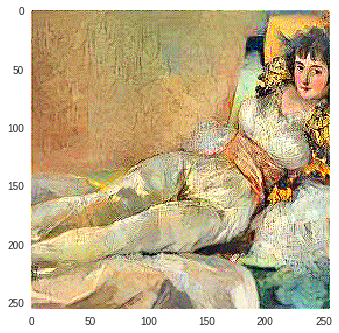

In [161]:
unloader = transforms.ToPILImage()  # reconvert into PIL image

def imshow(tensor, title=None):
    image = tensor.cpu().clone()  # we clone the tensor to not do changes on it
    image = image.squeeze(0)      # remove the fake batch dimension
    image = unloader(image)
    plt.imshow(image)
    plt.grid("off")

imshow(output)
#from skimage import io
#io.imsave("/content/drive/My Drive/Neural Transfer/result/1e6.jpg",output.squeeze(0))

In [0]:
tt = output.squeeze(0)
t = unloader(tt.cpu().detach())
io.imsave("/content/drive/My Drive/Neural Transfer/result/2_Gatys_collection.jpg",t)

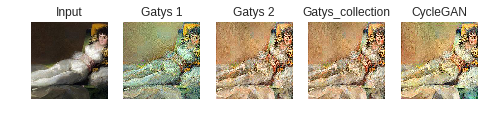

In [164]:
img1 = io.imread("/content/drive/My Drive/Neural Transfer/result/2.jpg")
img2 = io.imread("/content/drive/My Drive/Neural Transfer/result/2_Gatys.jpg")
img3 = io.imread("/content/drive/My Drive/Neural Transfer/result/2_Gatys2.jpg")
img4 = io.imread("/content/drive/My Drive/Neural Transfer/result/2_Gatys_collection.jpg")
img5 = io.imread("/content/drive/My Drive/Neural Transfer/result/2R_cyclegan.png")

fig = plt.figure()

ax = plt.subplot(1, 5, 1)
ax.axis('off')
plt.imshow(img1)
ax.set_title('{}'.format("Input"))

ax = plt.subplot(1, 5, 2)
ax.axis('off')
plt.imshow(img2)
ax.set_title('{}'.format("Gatys 1"))

ax = plt.subplot(1, 5, 3)
ax.axis('off')
plt.imshow(img3)
ax.set_title('{}'.format("Gatys 2"))

ax = plt.subplot(1, 5, 4)
ax.axis('off')
plt.imshow(img3)
ax.set_title('{}'.format("Gatys_collection"))

ax = plt.subplot(1, 5, 5)
ax.axis('off')
plt.imshow(img4)
ax.set_title('{}'.format("CycleGAN"))

fig.savefig("/content/drive/My Drive/Neural Transfer/result/Comparison.png")